In [10]:
from zipline.api import order_target_percent, record, symbol, schedule_function, date_rules, order
from zipline.api import set_commission, commission, set_slippage, slippage
from zipline import run_algorithm
from zipline.utils.events import time_rules

import pandas as pd
import numpy as np

import requests
from datetime import datetime

In [4]:
RETS_FILE_PATH = 'historical_returns.csv'

In [5]:
def get_weights_for_date(date):
  
    # The base URL of your Flask application
    base_url = "http://localhost:5000/get_weights"
    
    # Prepare the query parameters
    params = {'date': str(date)}
    
    try:
        # Sending a GET request to the endpoint
        response = requests.get(base_url, params=params)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()
            return data.get('weights')
        else:
            # Handle possible errors (e.g., invalid date format, missing date parameter)
            print(f"Error: {response.json()['error']}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [30]:
# Define the initialize function
def initialize(context):
    # Per-share commission model ($0.005 per share)
    set_commission(commission.PerShare(cost=0.005, min_trade_cost=None))
    # Slippage model: Assuming 0.05% slippage per trade
    #set_slippage(slippage.VolumeShareSlippage(volume_limit=0.025, price_impact=0.0005))

    
    context.tickers = ['VWO', 'SPY', 'VNQ', 'LQD', 'DBC']
    context.assets = [symbol(ticker) for ticker in context.tickers]
    
    # Schedule the rebalance function to run every Monday at market open
    schedule_function(rebalance, date_rules.week_start(), time_rules.market_open())
    # Set the context attributes needed
    context.lookback_days = 50 # look back over 50 days for the moving average

# Define the rebalance function
def rebalance(context, data):
    #print(context.get_datetime().date())
     
    # Get historical data for the assets
    historical_data = data.history(context.assets, "price", context.lookback_days + 1, "1d")
    
#     # Calculate daily returns
    daily_returns = historical_data.pct_change().dropna()
    daily_returns.to_csv(RETS_FILE_PATH)
    current_date = context.get_datetime().date()
    
    print(f'Handling {current_date}')
    
    weights = get_weights_for_date(current_date)
    
    # Place orders
    for asset, weight in zip(context.assets, weights):
        if data.can_trade(asset):
            order_target_percent(asset, weight)
            #print(f'ordered {asset}: {weight}')
    
    # Record some metrics
    record(weights=weights)

# Define the analyze function (optional)
def analyze(context, perf):
    # Plot portfolio weights over time
    #perf.weights.plot()
    pass

In [31]:

start_date = pd.Timestamp('2020-12-15', tz='UTC')
end_date = pd.Timestamp('2023-12-15', tz='UTC') # 2023
capital_base = 1e7

perf = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    capital_base=capital_base,
    data_frequency='daily',
    bundle='thesis1' 
)

C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Handling 2020-12-21


C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Handling 2020-12-28
Handling 2021-01-04
Handling 2021-01-11
Handling 2021-01-19
Handling 2021-01-25
Handling 2021-02-01
Handling 2021-02-08
Handling 2021-02-16
Handling 2021-02-22
Handling 2021-03-01
Handling 2021-03-08
Handling 2021-03-15
Handling 2021-03-22
Handling 2021-03-29
Handling 2021-04-05
Handling 2021-04-12
Handling 2021-04-19
Handling 2021-04-26
Handling 2021-05-03
Handling 2021-05-10
Handling 2021-05-17
Handling 2021-05-24
Handling 2021-06-01
Handling 2021-06-07
Handling 2021-06-14
Handling 2021-06-21
Handling 2021-06-28
Handling 2021-07-06
Handling 2021-07-12
Handling 2021-07-19
Handling 2021-07-26
Handling 2021-08-02
Handling 2021-08-09
Handling 2021-08-16
Handling 2021-08-23
Handling 2021-08-30
Handling 2021-09-07
Handling 2021-09-13
Handling 2021-09-20
Handling 2021-09-27
Handling 2021-10-04
Handling 2021-10-11
Handling 2021-10-18
Handling 2021-10-25
Handling 2021-11-01
Handling 2021-11-08
Handling 2021-11-15
Handling 2021-11-22
Handling 2021-11-29
Handling 2021-12-06


In [34]:
LINEAR_OSHARPE = 'linear_osharpe'
SPY = 'SPY'
perf.to_csv(fr'..\analytics\perfs\{LINEAR_OSHARPE}_perf.csv')

# Analytics

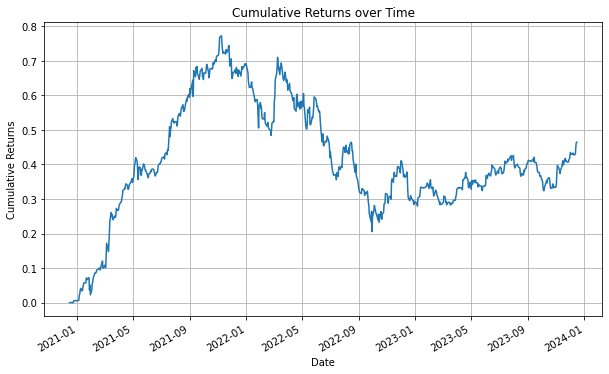

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate Cumulative Returns
# Assuming `perf` has a column 'returns' for daily returns
cumulative_returns = (1 + perf['returns']).cumprod() - 1

# Step 2: Plot the Cumulative Returns
plt.figure(figsize=(10, 6))
cumulative_returns.plot()

plt.title('Cumulative Returns over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

In [33]:
import empyrical as ep

# Assuming 'perf' is your DataFrame and it has a 'returns' column

# Cumulative returns
cumulative_returns = ep.cum_returns_final(perf['returns'])

# Annualized returns
annualized_returns = ep.annual_return(perf['returns'])

# Sharpe ratio
sharpe_ratio = ep.sharpe_ratio(perf['returns'])

# Max drawdown
max_drawdown = ep.max_drawdown(perf['returns'])

print(f"mean_returns: {perf[perf['returns'] != 0]['returns'].mean()}")
print(f"std: {perf[perf['returns'] != 0]['returns'].std()}")

print(f"Cumulative Returns: {cumulative_returns}")
print(f"Annualized Returns: {annualized_returns}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")


mean_returns: 0.0005574227994609832
std: 0.010097592646310289
Cumulative Returns: 0.46429407497349784
Annualized Returns: 0.13517747170407723
Sharpe Ratio: 0.8734289268810499
Max Drawdown: -0.31979454052990164


In [97]:
tmp['t'].shape

KeyError: 't'

# The server

In [60]:
!pip install flask

     -------------------------------------- 101.3/101.3 KB 6.1 MB/s eta 0:00:00
     -------------------------------------- 133.2/133.2 KB 7.7 MB/s eta 0:00:00
     ---------------------------------------- 97.9/97.9 KB ? eta 0:00:00
     ------------------------------------- 226.7/226.7 KB 14.4 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.1.2
    Uninstalling Werkzeug-2.1.2:
      Successfully uninstalled Werkzeug-2.1.2
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 3.1.1
    Uninstalling Jinja2-3.1.1:
      Successfully uninstalled Jinja2-3.1.1
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
    Uninstalling blinker-1.4:
      Successfully uninstalled blinker-1.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires sklearn, which is not installed.
spacy 3.2.4 requires click<8.1.0, but you have click 8.1.7 which is incompatible.


In [59]:
from flask import Flask, request, jsonify
import numpy as np

app = Flask(__name__)

@app.route('/get_weights', methods=['GET'])
def get_vector():
    # Extract date-time string from the query parameters
    date_time = request.args.get('date_time', None)
    
    # Simple validation to check if date_time is provided
    if not date_time:
        return jsonify({"error": "Missing date_time parameter"}), 400

    # For demonstration, generate a random 5-dimensional vector
    # Here, you can replace this part with your logic to generate or select a vector based on the date_time
    vector = np.random.rand(5).tolist()

    # Return the vector as JSON
    return jsonify({"date_time": date_time, "vector": vector})

ModuleNotFoundError: No module named 'flask'